# Notebook de Alexandre

Ici, Alexandre peut faire ses tests pour les parties du sujet dont il s'occupe.

Bon courage Alexandre :)

## Import necessary libraries

In [426]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shutil as su
import random as rd
import cv2

## Load data

In [427]:
%%bash
mkdir -p tmp_data
rm -rf tmp_data/*
mkdir -p tmp_data/train_set
mkdir -p tmp_data/test_set

## Separate training dataset

In [428]:
def separate_data(path, nb_elements=1):
    """
    Separate given data in `path` in two sets with `nb_elements` per class for test

    Parameters
    ----------
    path: str
        Path to directory where dataset files are stored.

    nb_elements: integer
        Defines the number of test images taken in each class of the dataset
    """
    labels_path = os.path.join(path, "labels.txt")
    images_path = path
    test_path = 'tmp_data/test_set'
    train_path = 'tmp_data/train_set'

    
    labels = np.empty((0, 1))
    names = np.empty((0, 1))
    with open(labels_path) as f:
        for current_label in f:
            if current_label == "\n":
                continue
            label, name = current_label.split(": ")
            labels = np.append(labels, label)
            names = np.append(names, name)

    for label in labels:
        pre_label = 'img_' + label + '_'
        curr_test_path = os.path.join(test_path, label)
        curr_train_path = os.path.join(train_path, label)
        os.makedirs(curr_test_path, exist_ok=True)
        os.makedirs(curr_train_path, exist_ok=True)

        current_path = os.path.join(images_path, label)
        datas = os.listdir(current_path)
        rd.shuffle(datas)

        count = 0
        for data in datas:
            data_path = os.path.join(current_path, data)
            if count < nb_elements:
                su.copyfile(data_path, os.path.join(curr_test_path, pre_label + str(count) + '.png'))
            else:
                su.copyfile(data_path, os.path.join(curr_train_path, pre_label + str(count - nb_elements) + '.png'))
            count += 1

    return labels, names

In [429]:
ref = separate_data('ressources/train', 2)

## Get separated datasets

In [430]:
def get_datasets(kind='train'):
    """
    Returns `kind` set and their label

    Parameters
    ----------
    kind: str (train or test)
        Type of dataset we want to get
    """
    assert kind == 'train' or kind == 'test'
    dataset_path = 'tmp_data/train_set' if kind == 'train' else 'tmp_data/test_set'
    
    images = []
    labels = []
    dirs = os.listdir(dataset_path)

    for folder in dirs : 
        curr_path = os.path.join(dataset_path, folder)
        datas = os.listdir(curr_path)
        for data in datas:
            data_path = os.path.join(curr_path, data)
            img = cv2.imread(data_path);
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
            images.append(img)
            labels.append(folder)
    
    return labels, images

In [431]:
train_labels, train_images = get_datasets('train')
test_labels, test_images = get_datasets('test')

## Shuffle datasets

In [432]:
def shuffle_set(labels, images):
    """
    Shuffles equally labels and images

    Parameters
    ----------
    labels: [str]
        Dataset's labels
        
    images: [image]
        Dataset's images
    """
    assert len(labels) == len(images)
    shuffle_index = np.arange(len(labels))
    np.random.shuffle(shuffle_index)
    new_labels = np.array(labels)
    new_images = np.array(images, dtype=object)
    
    for ii in range(shuffle_index.size):
        new_labels[ii] = labels[shuffle_index[ii]]
        new_images[ii] = images[shuffle_index[ii]]
        
    return new_labels, new_images

In [433]:
#train_labels, train_images = shuffle_set(train_labels, train_images)
#test_labels, test_images = shuffle_set(test_labels, test_images)

## Print train example

01
['lunettes\n']


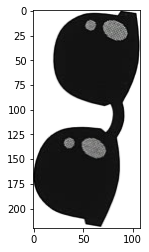

In [434]:
print(train_labels[0])
plt.imshow(train_images[0])
print(ref[1][np.where(ref[0] == train_labels[0])])

## Print test example

01
['lunettes\n']


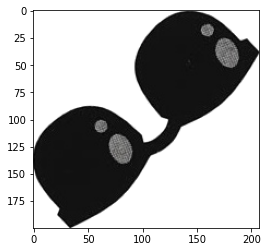

In [435]:
print(test_labels[0])
plt.imshow(test_images[0])
print(ref[1][np.where(ref[0] == test_labels[0])])

## Summary

If you executed all of the above, you defined the following variables:

```python
ref # couple:
    ref[0] # labels' identifiers
    ref[1] # labels

train_labels # train dataset's images' identifiers for labels

train_images # train dataset's images

test_labels # test dataset's images' identifiers for labels

test_images # test dataset's images
```

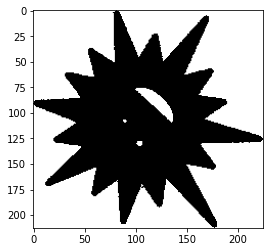

In [436]:
def is_white(pixel):
    sum_rgb = int(pixel[0]) + int(pixel[1]) + int(pixel[2])
    return sum_rgb > 700

def binarize(img):
    ret = img.copy()
    for i in range(len(img)):
        for j in range(len(img[0])):
            if is_white(img[i][j]):
                ret[i][j] = [255, 255, 255]
            else:
                ret[i][j] = [0, 0, 0]
    return ret

binary = binarize(train_images[156])
plt.imshow(binary)

4


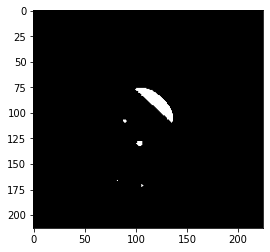

In [443]:
def img_from_binary_map(img_map):
    img = np.zeros((len(img_map),len(img_map[0]),3), np.uint8)
    for i in range(len(img_map)):
        for j in range(len(img_map[0])):
            if img_map[i][j] == 0:
                img[i][j] = [0,0,0]
            else:
                img[i][j] = [255, 255, 255]
    return img

def fill_map(img, img_map, i, j):
    if img_map[i][j] == 1 or not is_white(img[i][j]):
        return True

    img_map[i][j] = 1

    up = False
    down = False
    left = False
    right = False
    if (not i - 1 < 0):
        up = fill_map(img, img_map, i - 1, j)
    if (not i + 1 >= len(img_map)):
        down = fill_map(img, img_map, i + 1, j)
    if (not j - 1 < 0):
        left = fill_map(img, img_map, i, j - 1)
    if (not j + 1 >= len(img_map[0])):
        right = fill_map(img, img_map, i, j + 1)
    
    return up and down and left and right

def find_holes(img):
    img_map = [[0 for _ in range(len(img[0]))] for _ in range(len(img))]
    edited = True
    while edited:
        edited = False
        for i in range(len(img_map)):
            for j in range(len(img_map[0])):
                if img_map[i][j] == 0 and is_white(img[i][j]) and ((j == 0 or img_map[i][j-1] == 1) or (i == 0 or img_map[i-1][j] == 1)):
                    img_map[i][j] = 1
                    edited = True

            for j in reversed(range(len(img_map[0]))):
                if img_map[i][j] == 0 and is_white(img[i][j]) and ((j == len(img[0]) - 1 or img_map[i][j+1] == 1) or (i == 0 or img_map[i-1][j] == 1)):
                    img_map[i][j] = 1
                    edited = True

        for i in reversed(range(len(img_map))):
            for j in range(len(img_map[0])):
                if img_map[i][j] == 0 and is_white(img[i][j]) and ((j == 0 or img_map[i][j-1] == 1) or (i == len(img_map) - 1 or img_map[i+1][j] == 1)):
                    img_map[i][j] = 1
                    edited = True

            for j in reversed(range(len(img_map[0]))):
                if img_map[i][j] == 0 and is_white(img[i][j]) and ((j == len(img[0]) - 1 or img_map[i][j+1] == 1) or (i == len(img_map) - 1 or img_map[i+1][j] == 1)):
                    img_map[i][j] = 1
                    edited = True

        for j in range(len(img_map[0])):
            for i in range(len(img_map)):
                if img_map[i][j] == 0 and is_white(img[i][j]) and ((j == 0 or img_map[i][j-1] == 1) or (i == 0 or img_map[i-1][j] == 1)):
                    img_map[i][j] = 1
                    edited = True

            for i in reversed(range(len(img_map))):
                if img_map[i][j] == 0 and is_white(img[i][j]) and ((j == 0 or img_map[i][j-1] == 1) or (i == len(img_map) - 1 or img_map[i+1][j] == 1)):
                    img_map[i][j] = 1
                    edited = True

        for j in reversed(range(len(img_map[0]))):
            for i in range(len(img_map)):
                if img_map[i][j] == 0 and is_white(img[i][j]) and ((j == len(img[0]) - 1 or img_map[i][j+1] == 1) or (i == 0 or img_map[i-1][j] == 1)):
                    img_map[i][j] = 1
                    edited = True

            for i in reversed(range(len(img_map))):
                if img_map[i][j] == 0 and is_white(img[i][j]) and ((j == len(img[0]) - 1 or img_map[i][j+1] == 1) or (i == len(img_map) - 1 or img_map[i+1][j] == 1)):
                    img_map[i][j] = 1
                    edited = True
            
    holes = np.zeros((len(img_map),len(img_map[0]),3), np.uint8)
    for i in range(len(img_map)):
        for j in range(len(img_map[0])):
            if img_map[i][j] == 0 and is_white(img[i][j]):
                holes[i][j] = [255, 255, 255]

    plt.imshow(holes)

    nb_holes = 0
    void_prec = True
    for i in range(len(img_map)):
        for j in range(len(img_map[0])):
            if img_map[i][j] == 0 and is_white(img[i][j]):
                if void_prec:
                    nb_holes += 1
                    void_prec = False
                break
            elif j == len(img_map[0]) - 1:
                void_prec = True
                
    print(nb_holes)

find_holes(binary)

In [438]:
img_map = [[0]*3]*3
print(img_map)
img_map[0][0] = 1
print(img_map)

[[0, 0, 0], [0, 0, 0], [0, 0, 0]]
[[1, 0, 0], [1, 0, 0], [1, 0, 0]]


In [439]:
img_map = [[0 for i in range(3)] for j in range(3)]
print(img_map)
img_map[0][0] = 1
print(img_map)

[[0, 0, 0], [0, 0, 0], [0, 0, 0]]
[[1, 0, 0], [0, 0, 0], [0, 0, 0]]
